In [1]:
from functools import partial
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
from rlaopt.kernels import RBFLinOp, Matern12LinOp, Matern32LinOp, Matern52LinOp
import torch
from torch.distributions import Distribution, Normal, StudentT

In [2]:
def _random_features(X: torch.Tensor, lengthscale: Union[float, torch.Tensor], num_features: int, Omega_dist: Distribution) -> torch.Tensor:
    X_whitened = X / lengthscale

    scale_factor = (2.0 / num_features) ** 0.5
    # The sample method adds an extra dimension since the distribution parameters are tensors, so we need to squeeze it out
    Omega = Omega_dist.sample((X_whitened.shape[1], num_features)).squeeze(-1)
    B = 2 * torch.pi * torch.rand(num_features, device=X.device, dtype=X.dtype)
    return scale_factor * torch.cos(X_whitened @ Omega + B)


def rbf_random_features(X: torch.Tensor, lengthscale: Union[float, torch.Tensor], num_features: int) -> torch.Tensor:
    loc = torch.tensor([0.0], device=X.device, dtype=X.dtype)
    scale = torch.tensor([1.0], device=X.device, dtype=X.dtype)
    return _random_features(X, lengthscale, num_features, Normal(loc=loc, scale=scale))


def matern_random_features(X: torch.Tensor, lengthscale: Union[float, torch.Tensor], num_features: int, nu: float) -> torch.Tensor:
    df = torch.tensor([2.0 * nu], device=X.device, dtype=X.dtype)
    loc = torch.tensor([0.0], device=X.device, dtype=X.dtype)
    scale = torch.tensor([1.0], device=X.device, dtype=X.dtype)
    return _random_features(X, lengthscale, num_features, StudentT(df=df, loc=loc, scale=scale))

In [3]:
torch.set_default_dtype(torch.float64)
torch.manual_seed(0)

In [4]:
device = torch.device("cuda:0")

n = 4
d = 10
lengthscale_scalar = 0.1
lengthscale_tensor = torch.tensor([0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2], device=device)
num_features_grid = [10 ** 2, 10 ** 3, 10 ** 4, 10 ** 5, 10 ** 6, 10 ** 7, 10 ** 8]

X = torch.randn(n, d, device=device) / (d ** 0.5)

idx1 = 0
idx2 = 0

In [5]:
def test_rf_fn(kernel_linop_class, rf_fn, X, lengthscale, num_features):
    kernel_linop = kernel_linop_class(X, X, {"lengthscale": lengthscale})
    K_true = kernel_linop @ torch.eye(kernel_linop.shape[1], device=kernel_linop.device)
    K_rf = rf_fn(X, lengthscale, num_features)
    K_approx = K_rf @ K_rf.T
    return K_true - K_approx


def test_rf_fn_grid(kernel_linop_class, rf_fn, X, lengthscale, num_features_grid, n_trials=30, idx1=0, idx2=0):
    diffs_at_loc = {}
    for num_features in num_features_grid:
        diff = 0.0
        for _ in range(n_trials):
            K_diff = test_rf_fn(kernel_linop_class, rf_fn, X, lengthscale, num_features)
            diff += K_diff[idx1, idx2].item()
        diff /= n_trials
        diffs_at_loc[num_features] = abs(diff)
    return diffs_at_loc


def plot_diffs(diffs, title):
    x_vals = np.array(list(diffs.keys()))
    y_vals = np.abs(np.array(list(diffs.values())))
    plt.semilogy(x_vals, y_vals)
    plt.xscale("log")
    plt.xlabel("Number of random features")
    plt.ylabel("Error")
    plt.title(title)
    plt.show()

RBF

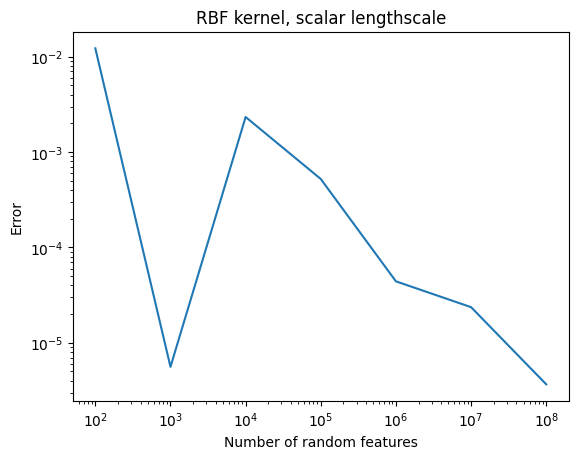

In [6]:
diffs_00 = test_rf_fn_grid(RBFLinOp, rbf_random_features, X, lengthscale_scalar, num_features_grid, idx1=idx1, idx2=idx2)
plot_diffs(diffs_00, "RBF kernel, scalar lengthscale")

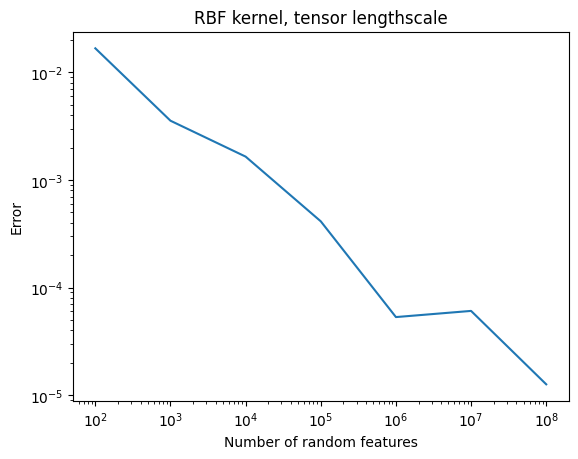

In [7]:
diffs_00 = test_rf_fn_grid(RBFLinOp, rbf_random_features, X, lengthscale_tensor, num_features_grid, idx1=idx1, idx2=idx2)
plot_diffs(diffs_00, "RBF kernel, tensor lengthscale")

Matern-1/2

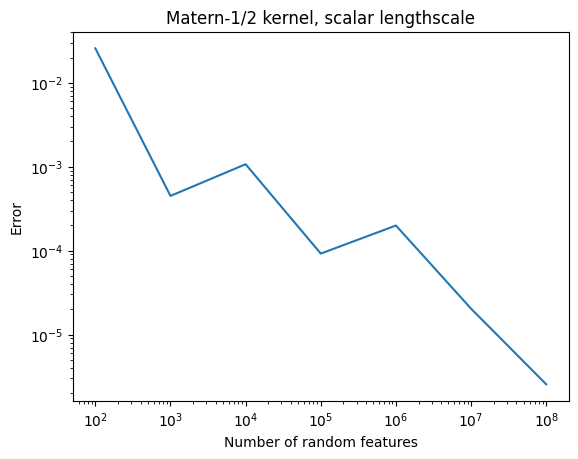

In [8]:
diffs_00 = test_rf_fn_grid(Matern12LinOp, partial(matern_random_features, nu=0.5), X, lengthscale_scalar, num_features_grid, idx1=idx1, idx2=idx2)
plot_diffs(diffs_00, "Matern-1/2 kernel, scalar lengthscale")

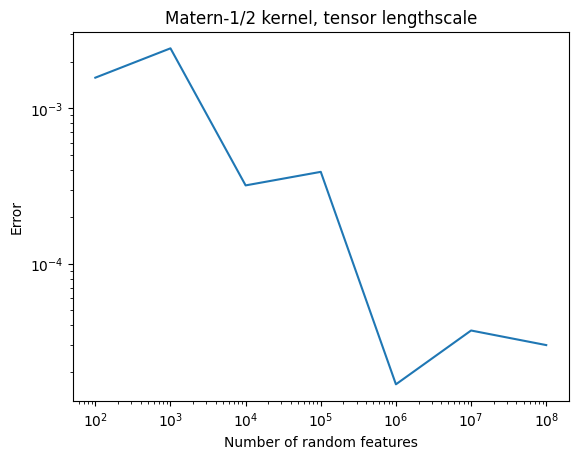

In [9]:
diffs_00 = test_rf_fn_grid(Matern12LinOp, partial(matern_random_features, nu=0.5), X, lengthscale_tensor, num_features_grid, idx1=idx1, idx2=idx2)
plot_diffs(diffs_00, "Matern-1/2 kernel, tensor lengthscale")

Matern-3/2

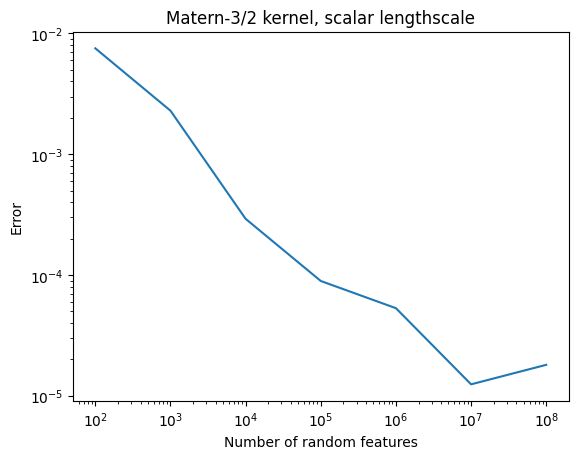

In [10]:
diffs_00 = test_rf_fn_grid(Matern32LinOp, partial(matern_random_features, nu=1.5), X, lengthscale_scalar, num_features_grid, idx1=idx1, idx2=idx2)
plot_diffs(diffs_00, "Matern-3/2 kernel, scalar lengthscale")

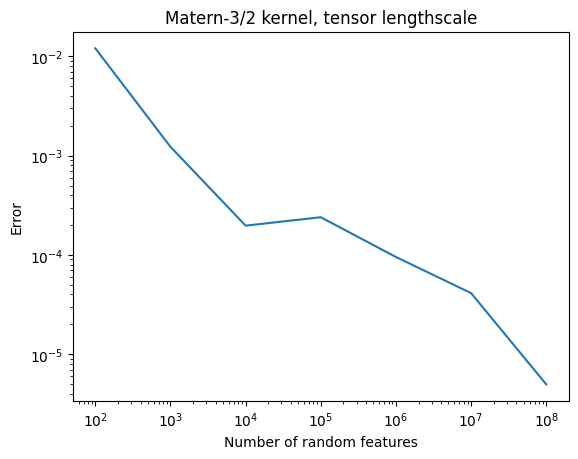

In [11]:
diffs_00 = test_rf_fn_grid(Matern32LinOp, partial(matern_random_features, nu=1.5), X, lengthscale_tensor, num_features_grid, idx1=idx1, idx2=idx2)
plot_diffs(diffs_00, "Matern-3/2 kernel, tensor lengthscale")

Matern-5/2

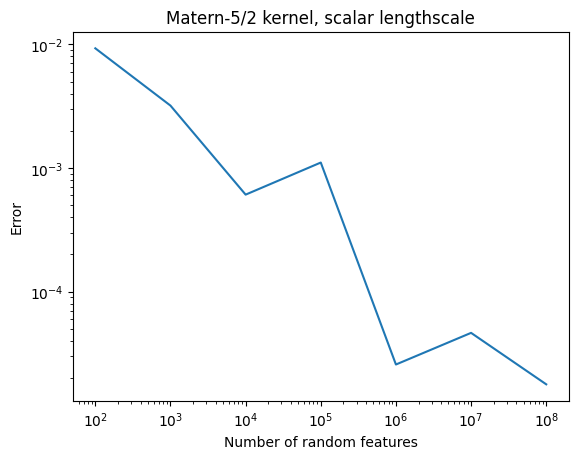

In [12]:
diffs_00 = test_rf_fn_grid(Matern52LinOp, partial(matern_random_features, nu=2.5), X, lengthscale_scalar, num_features_grid, idx1=idx1, idx2=idx2)
plot_diffs(diffs_00, "Matern-5/2 kernel, scalar lengthscale")

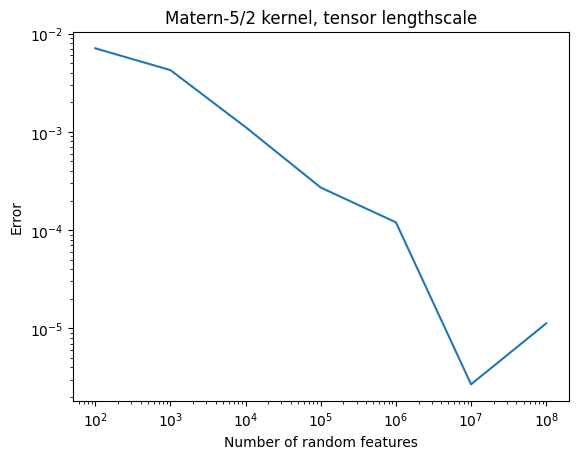

In [13]:
diffs_00 = test_rf_fn_grid(Matern52LinOp, partial(matern_random_features, nu=2.5), X, lengthscale_tensor, num_features_grid, idx1=idx1, idx2=idx2)
plot_diffs(diffs_00, "Matern-5/2 kernel, tensor lengthscale")